# False Alarm Probabilities

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

In [2]:
def make_data(N, T=100, period=0.6, amp=(1, 0.6, 0.3), err=0.1,
              err_range=0.0, alias_period=1, alias_level=0,
              return_model=False, rseed=None):
    rng = np.random.RandomState(rseed)
    t = T * rng.rand(N)
    t -= (t % alias_period) * alias_level
    phase = rng.rand(len(amp))[:, None]
    def model(t, amp=amp, phase=phase, period=period):
        k = np.arange(1, len(amp) + 1)[:, None]
        return np.dot(amp, np.sin(2 * np.pi * k * (t - phase) / period))
    dy = err + err_range * np.random.rand(N)
    y = model(t) + dy * rng.randn(N)
    if return_model:
        return t, y, dy, model
    else:
        return t, y, dy

## Baluev Method

In [3]:
from scipy.special import gammaln


def weighted_sum(val, dy):
    return (val / dy ** 2).sum()


def weighted_mean(val, dy):
    return weighted_sum(val, dy) / weighted_sum(np.ones_like(val), dy)


def weighted_var(val, dy):
    return weighted_mean(val ** 2, dy) - weighted_mean(val, dy) ** 2


def gamma(N):
    # Note: this is closely approximated by (1 - 1 / N) for large N
    return np.sqrt(2 / N) * np.exp(gammaln(N / 2) - gammaln((N - 1) / 2))


def FAP_single(Z, N, normalization='standard'):
    """False Alarm Probability for a single observation"""
    NH = N - 1  # DOF for null hypothesis
    NK = N - 3  # DOF for periodic hypothesis
    if normalization == 'psd':
        return np.exp(-Z)
    elif normalization == 'standard':
        # Note: astropy's standard normalization is Z = 2/NH * z_1 in Baluev's terms
        return (1 - Z) ** (NK / 2)
    elif normalization == 'model':
        # Note: astropy's model normalization is Z = 2/NK * z_2 in Baluev's terms
        return (1 + Z) ** -(NK / 2)
    elif normalization == 'log':
        # Note: astropy's log normalization is Z = 2/NK * z_3 in Baluev's terms
        return np.exp(-0.5 * NK * Z)
    else:
        raise NotImplementedError("normalization={0}".format(normalization))
        

def P_single(Z, N, normalization='standard'):
    """Cumulative Probability for a single observation"""
    return 1 - FAP_single(Z, N, normalization=normalization)
        
    
def FAP_estimated(Z, N, fmax, t, normalization='standard'):
    """False Alarm Probability based on estimated number of indep frequencies"""
    T = max(t) - min(t)
    N_eff = fmax * T
    return 1 - P_single(Z, N, normalization=normalization) ** N_eff


def tau_davies(Z, N, fmax, t, y, dy, normalization='standard'):
    """tau factor for estimating Davies bound (see Baluev 2008, Table 1)"""
    # Variable names follow the discussion in Baluev 2008
    NH = N - 1  # DOF for null hypothesis
    NK = N - 3  # DOF for periodic hypothesis
    Dt = weighted_var(t, dy)
    Teff = np.sqrt(4 * np.pi * Dt)
    W = fmax * Teff
    if normalization == 'psd':
        return W * np.exp(-Z) * np.sqrt(Z)
    elif normalization == 'standard':
        # Note: astropy's standard normalization is Z = 2/NH * z_1 in Baluev's terms
        return gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(NH * Z / 2)
    elif normalization == 'model':
        # Note: astropy's model normalization is Z = 2/NK * z_2 in Baluev's terms
        return gamma(NK) * W * (1 + Z) ** (- 0.5 * NK) * np.sqrt(NK * Z / 2)
    elif normalization == 'log':
        # Note: astropy's log normalization is Z = 2/NK * z_3 in Baluev's terms
        return gamma(NK) * W * np.exp(-0.5 * Z * (NK - 0.5)) * np.sqrt(NK * np.sinh(0.5 * Z))
    else:
        raise NotImplementedError("normalization={0}".format(normalization))

    
def FAP_davies(Z, N, fmax, t, y, dy, normalization='standard'):
    """Davies bound (Eqn 5 of Baluev 2008)"""
    FAP_s = FAP_single(Z, N, normalization=normalization)
    tau = tau_davies(Z, N, fmax, t, y, dy, normalization=normalization)
    return FAP_s + tau


def FAP_aliasfree(Z, N, fmax, t, y, dy, normalization='standard'):
    """Alias-free approximation to FAP (Eqn 6 of Baluev 2008)"""
    P_s = P_single(Z, N, normalization=normalization)
    tau = tau_davies(Z, N, fmax, t, y, dy, normalization=normalization)
    return 1 - P_s * np.exp(-tau)

In [4]:
def FAP_bootstrap(Z, t, y, dy, fmax, n_bootstraps=1000,
                  random_seed=None, normalization='standard'):
    rng = np.random.RandomState(random_seed)
    
    def bootstrapped_power():
        resample = rng.randint(0, len(y), len(y))  # sample with replacement
        ls_boot = LombScargle(t, y[resample], dy[resample])
        freq, power = ls_boot.autopower(normalization=normalization,
                                        maximum_frequency=fmax)
        return power.max()
    
    pmax = np.array([bootstrapped_power() for i in range(n_bootstraps)])
    pmax.sort()
    
    return 1 - np.searchsorted(pmax, Z) / len(pmax)

In [5]:
import os
def cached(filename, overwrite=False):
    def decorator(func):
        def new_func(*args, **kwargs):
            if overwrite or not os.path.exists(filename):
                np.save(filename, func(*args, **kwargs))
            return np.load(filename)
        return new_func
    return decorator

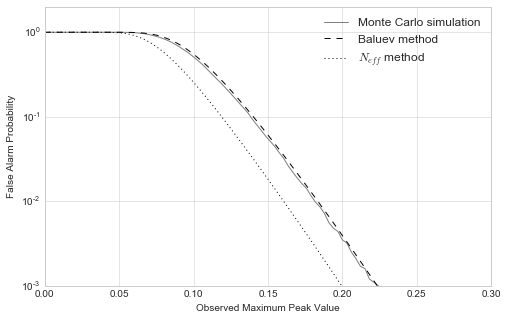

In [6]:
Z = np.linspace(0, 0.3, 100)
fmax = 10
T = 5
N = 100
normalization='standard'

t, y, dy = make_data(N=N, T=T, amp=[0], err=1.0, err_range=0.0, rseed=1324)
FAP_bootstrap_cached = cached('FAP-cache.npy', overwrite=False)(FAP_bootstrap)
FAP_boot = FAP_bootstrap_cached(Z, t, y, dy, fmax=fmax, normalization=normalization,
                                n_bootstraps=10000, random_seed=1324)

fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(Z, FAP_boot, '-', color='gray', label='Monte Carlo simulation')
ax.semilogy(Z, FAP_aliasfree(Z, N, fmax, t, y, dy, normalization=normalization), '--k', label='Baluev method')
ax.semilogy(Z, FAP_estimated(Z, N, fmax, t, normalization=normalization), ':k', label='$N_{eff}$ method')

ax.legend()

ax.set(xlim=(Z.min(), Z.max()), ylim=(1E-3, 2),
       xlabel='Observed Maximum Peak Value',
       ylabel='False Alarm Probability');

fig.savefig('fig27_FAP_bootstrap.pdf')